# k-NN, Decision Tree, Random Forest, SVM, Neural Network + Bagging, Boosting, CV, Grid Search

##### Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error


##### Functions from the exercises

In [40]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def weighted_knn(K, X, n):
    yhat = np.zeros(n)
    distances = np.zeros(n)
    # For each obs, compare distance to all other points in X
    for i in range(n):
        for j in range(n):
            distances[j] = distance.euclidean(X[i,:], X[j, :])

        # Sort all the distances
        idx = np.argsort(distances)[1:(K + 1)] # Skip first, as distance to "itself" does not make sense
        Wt = sum(distances[idx]) # Weight of k nearest neighbors
        W = distances[idx] / Wt # Weighing average


        yhat[i] = np.matmul(W.T, y[idx]) # Final value is weighted combination of neighbours
    
    return yhat



In [41]:
from sklearn.base import BaseEstimator, RegressorMixin

class WeightedKNNRegressor(BaseEstimator, RegressorMixin):
	def __init__(self, K):
		self.K = K

	def fit(self, X, y):
		self.X = X
		self.y = y

	def predict(self, X):
		n = X.shape[0]
		yhat = np.zeros(n)
		for i in range(n):
			distances = np.array([distance.euclidean(X[i], x) for x in self.X])
			idx = np.argsort(distances)[:self.K]
			Wt = sum(distances[idx])
			W = distances[idx] / Wt
			yhat[i] = np.dot(W, self.y[idx])
		return yhat

##### Load and format data

In [42]:
data = pd.read_csv('./Data/case1Data.csv')
y = np.array(data['y'])
X = np.array(data.drop('y', axis=1).fillna(data.mean()))

In [43]:
pca = PCA(n_components=0.9)
pca_plot = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_plot = pca_plot.fit_transform(X)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [44]:
X, mu = centerData(X)
X, d = normalize(X)
y = centerData(y)[0]
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1312)

(100, 100)
(100,)


##### Analyses

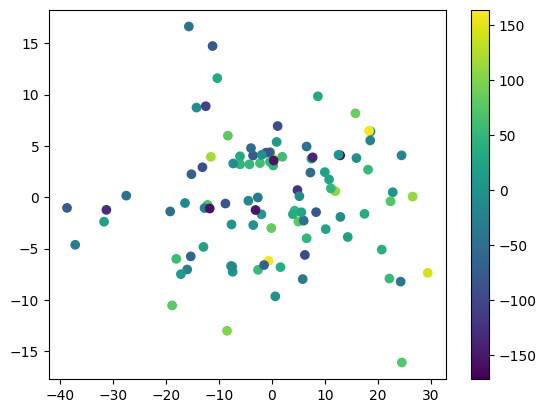

In [45]:
# Plot pca

plt.scatter(X_pca_plot[:,0], X_pca_plot[:,1], c=y, cmap='viridis')
plt.colorbar()
plt.show()

#### Model selection

In [47]:
# Model defitinions
rf = RandomForestRegressor(random_state=1312)
dt = DecisionTreeRegressor(random_state=1312)
svr = SVR()
ada = AdaBoostRegressor(random_state=1312)
bag = BaggingRegressor(random_state=1312)
dt = DecisionTreeRegressor(random_state=1312)
knn = WeightedKNNRegressor(5)

In [48]:
# Cross validation, bagging, boosting and oob for optimization

# Define the models and their parameter grids
models = {
    'RandomForest': (RandomForestRegressor(random_state=1312), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'DecisionTree': (DecisionTreeRegressor(random_state=1312), {'max_depth': [None, 10, 20, 30]}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'KNN': (WeightedKNNRegressor(K=5), {'K': [5, 10, 20]}),
    'AdaBoost': (AdaBoostRegressor(random_state=1312), {'n_estimators': [50, 100, 200]}),
    'Bagging': (BaggingRegressor(random_state=1312), {'n_estimators': [10, 50, 100]})
}

# Perform grid search for each model
best_estimators = {}
for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Use boosting to improve the results
boosted_models = {
    'AdaBoost': AdaBoostRegressor(estimator=best_estimators['DecisionTree'], n_estimators=100, random_state=1312),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1312)
}

# Evaluate the boosted models using cross-validation
for name, model in boosted_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"RMSE for {name} with boosting: {rmse_scores.mean()}")

# Use bagging and cross-validation to estimate the RMSE generalization error
bagging_models = {
    'RandomForest': BaggingRegressor(estimator=best_estimators['RandomForest'], n_estimators=10, random_state=1312),
    'DecisionTree': BaggingRegressor(estimator=best_estimators['DecisionTree'], n_estimators=10, random_state=1312),
    'KNN': BaggingRegressor(estimator=best_estimators['KNN'], n_estimators=10, random_state=1312)
}

for name, model in bagging_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"RMSE for {name} with bagging: {rmse_scores.mean()}")

Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 100}
Best parameters for DecisionTree: {'max_depth': None}
Best parameters for SVR: {'C': 10, 'gamma': 'scale'}
Best parameters for KNN: {'K': 10}
Best parameters for AdaBoost: {'n_estimators': 100}
Best parameters for Bagging: {'n_estimators': 100}
RMSE for AdaBoost with boosting: 48.62719390395499
RMSE for GradientBoosting with boosting: 45.925126658872486
RMSE for RandomForest with bagging: 55.574545368610266
RMSE for DecisionTree with bagging: 54.34541676440277
RMSE for KNN with bagging: 64.44054750618446


In [51]:
# Perform grid search for each model
best_estimators_pca = {}
for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_pca_train, y_pca_train)
    best_estimators_pca[name] = grid_search.best_estimator_
    print(f"Best parameters for {name} with PCA: {grid_search.best_params_}")

# Use boosting to improve the results
boosted_models_pca = {
    'AdaBoost': AdaBoostRegressor(estimator=best_estimators_pca['DecisionTree'], n_estimators=100, random_state=1312),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1312)
}

# Evaluate the boosted models using cross-validation
for name, model in boosted_models_pca.items():
    scores_pca = cross_val_score(model, X_pca_train, y_pca_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores_pca = np.sqrt(-scores_pca)
    print(f"RMSE for {name} with boosting and PCA: {rmse_scores_pca.mean()}")

# Use bagging and cross-validation to estimate the RMSE generalization error
bagging_models_pca = {
    'RandomForest': BaggingRegressor(estimator=best_estimators_pca['RandomForest'], n_estimators=10, random_state=1312),
    'DecisionTree': BaggingRegressor(estimator=best_estimators_pca['DecisionTree'], n_estimators=10, random_state=1312),
    'KNN': BaggingRegressor(estimator=best_estimators_pca['KNN'], n_estimators=10, random_state=1312)
}

for name, model in bagging_models_pca.items():
    scores_pca = cross_val_score(model, X_pca_train, y_pca_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores_pca = np.sqrt(-scores_pca)
    print(f"RMSE for {name} with bagging and PCA: {rmse_scores_pca.mean()}")

RMSE for weighted knn with pca: 63.250091554707
Best parameters for RandomForest with PCA: {'max_depth': 10, 'n_estimators': 200}
Best parameters for DecisionTree with PCA: {'max_depth': 10}
Best parameters for SVR with PCA: {'C': 10, 'gamma': 'scale'}
Best parameters for KNN with PCA: {'K': 20}
Best parameters for AdaBoost with PCA: {'n_estimators': 200}
Best parameters for Bagging with PCA: {'n_estimators': 100}
RMSE for AdaBoost with boosting and PCA: 63.27911315184383
RMSE for GradientBoosting with boosting and PCA: 63.250165644814636
RMSE for RandomForest with bagging and PCA: 63.26093910074654
RMSE for DecisionTree with bagging and PCA: 67.24629257560078
RMSE for KNN with bagging and PCA: 62.21113019267494
